In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [ ]:
# Load the datasets
base_station_info = pd.read_csv('BSinfo.csv')
cell_level_data = pd.read_csv('CLdata.csv')
energy_consumption_data = pd.read_csv('ECdata.csv')
power = pd.read_csv("power_consumption_prediction.csv").drop("w", axis=1)

# Data Preprocessing

In [ ]:
base_station_info.CellName.value_counts()

CellName
Cell0    1020
Cell1     193
Cell2       2
Cell3       2
Name: count, dtype: int64

**Update on Data Structure Changes**

Given that multiple cells can be active in the same base station simultaneously, we've decided to update the structure of both `cell_level_data` and `base_station_info` to reflect this scenario.

**base_station_info Changes**:

We've introduced the following columns for `base_station_info` to detail the properties of the first cell:

- `RUType_1`
- `Mode_1`
- `Frequency_1`
- `Bandwidth_1`
- `Antennas_1`
- `TXpower_1`

These columns represent the RUType, Mode, and other attributes specific to `cell1`.

> **Note**: We opted to exclude `cell2` and `cell3` because they only appear twice each. Although they might offer minimal information, their inclusion would risk expanding our dataset dimensions significantly, increasing the likelihood of overfitting.

**cell_level_data Changes**:

For `cell_level_data`, we have incorporated the following columns:

- `load_1`
- `ESMode1_1`
- `ESMode2_1`
- `ESMode3_1`
- `ESMode6_1`

### base_station_info Changes:


In [ ]:
base_station_info = base_station_info[base_station_info.CellName.isin(['Cell0', 'Cell1'])]
df = base_station_info.copy()

# Filter rows where CellName is Cell1
cell1_df = df[df['CellName'] == 'Cell1'].copy()

# Rename columns
rename_columns = {
    'RUType': 'RUType_1',
    'Mode': 'Mode_1',
    'Frequency': 'Frequency_1',
    'Bandwidth': 'Bandwidth_1',
    'Antennas': 'Antennas_1',
    'TXpower': 'TXpower_1'
}
cell1_df.rename(columns=rename_columns, inplace=True)

# Drop the CellName column
cell1_df.drop(columns=['CellName'], inplace=True)

# Merge the modified dataframe with the original one based on the BS column
result_df = pd.merge(df, cell1_df, on='BS', how='left')

base_station_info = result_df[result_df.CellName=='Cell0']



**Key Point**: The parameters `Rutype` and `Mode` are solely dependent on the base station, not the active cell.

Given this, we can confidently say:
- `Rutype` is always equivalent to `Rutype_1`.
- `Mode` always matches `Mode_1`.

Therefore, we'll **eliminate** `Rutype_1` and `Mode_1` from our data.

In [ ]:
base_station_info.drop(columns=["Mode_1", 'RUType_1'], inplace=True)

base_station_info = base_station_info.fillna(-10)

### cell_level_data Changes:

In [ ]:
# ESmode4 and ESMode5 contains only 0 or (99.9% contains 0) so it's better to drop it
cell_level_data.drop(columns=["ESMode4", 'ESMode5'],inplace=True)

active_cells = cell_level_data.groupby(["BS", 'Time']).CellName.nunique()
cell_level_data['active_cells'] = cell_level_data.set_index(["BS", 'Time']).index.map(active_cells)

cell_level_data = cell_level_data[cell_level_data.CellName.isin(['Cell0', 'Cell1'])]

df = cell_level_data.copy()

# Filter rows where CellName is Cell1
cell1_df = df[df['CellName'] == 'Cell1'].copy()

# Rename columns
rename_columns = {
    'load': 'load_1',
    'ESMode1': 'ESMode1_1',
    'ESMode2': 'ESMode2_1',
    'ESMode3': 'ESMode3_1',
    'ESMode6': 'ESMode6_1'
}
cell1_df.rename(columns=rename_columns, inplace=True)

# Drop the CellName column
cell1_df.drop(columns=['CellName', 'active_cells'], inplace=True)

# Merge the modified dataframe with the original one based on the BS and Time columns
result_df = pd.merge(df, cell1_df, on=['BS', 'Time'], how='left')

cell_level_data = result_df[result_df.CellName=='Cell0']

cols = ['ESMode1_1', 'ESMode2_1', 'ESMode3_1',
       'ESMode6_1']
cell_level_data['load_1'] = cell_level_data['load_1'].fillna(0)
cell_level_data[cols] = cell_level_data[cols].fillna(-1)

**Cell-Level Data Processing:**

We're performing two specific operations on our `cell_level_data` dataframe:

1. **Summation of Load Values**:
   We are creating a new column, `load_sum`, that will store the combined values of the `load` and `load_1` columns for each row.

2. **Multiplication of Load Values**:
   Similarly, we introduce a new column, `load_mult`, that holds the product of the `load` and `load_1` columns for each row.


These operations help derive new insights from the existing load data.

In [ ]:
cell_level_data["load_sum"] = cell_level_data[["load", "load_1"]].sum(1)
cell_level_data["load_mult"] = cell_level_data["load"] * cell_level_data["load_1"]

The code cell below is specifically designed to match the time format present in both the *Power Consumption Data* and *Energy Consumption Data*.

In [ ]:
import re

def convert_datetime_format(date_str):
    match = re.match(r'(\d{4})-(\d{2})-(\d{2}) (\d{2}):(\d{2}):\d{2}', date_str)

    if match:
        # Extracting year, month, day, hour and minute from the match
        year, month, day, hour, minute = match.groups()

        # Convert to the desired format
        new_date_str = "{}/{}/{} {}:{}".format(int(month), int(day), year, int(hour), minute)

        return new_date_str
    else:
        return None  # Return None if the input string doesn't match the expected pattern

power['Time'] = power['Time'].apply(convert_datetime_format)

In [ ]:
energy_consumption_data["train"]=1
power["train"]=0

In [ ]:
data = pd.concat([energy_consumption_data,power])

In [ ]:
merged_data = pd.merge(cell_level_data, data, on=['Time', 'BS'], how='inner')
merged_data = pd.merge(merged_data, base_station_info, on=['BS', 'CellName'], how='left')
# Convert the 'Time' column to datetime format
merged_data['Time'] = pd.to_datetime(merged_data['Time'])
merged_data.drop(columns=["CellName"],inplace=True)
merged_data.head()

,Time,BS,load,ESMode1,ESMode2,ESMode3,ESMode6,active_cells,load_1,ESMode1_1,ESMode2_1,ESMode3_1,ESMode6_1,load_sum,load_mult,Energy,train,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Frequency_1,Bandwidth_1,Antennas_1,TXpower_1
0,2023-01-01 01:00:00,B_0,0.487936,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.487936,0.0,64.275037,1,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
1,2023-01-01 02:00:00,B_0,0.344468,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.344468,0.0,55.904335,1,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
2,2023-01-01 03:00:00,B_0,0.193766,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.193766,0.0,57.698057,1,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
3,2023-01-01 04:00:00,B_0,0.222383,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.222383,0.0,55.156951,1,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
4,2023-01-01 05:00:00,B_0,0.175436,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.175436,0.0,56.053812,1,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504


🎉 **Success!** We now have our finalized dataset, `merged_data`.

**Next Steps**:
- Dive into Exploratory Data Analysis for further understanding of the data



# Exploratory Data Analysis
Our EDA will be organized as follows:

1. **Univariate Analysis**: Analyze the distribution of individual variables in each dataset.
2. **Bivariate Analysis**: Analyze the relationship between different variables and energy consumption.
3. **Correlation Analysis**: Identify how different variables are correlated with each other.




### 1. Univariate Analysis

In this section, we will analyze the distribution of individual variables in the dataset. We'll visualize the distributions of key columns such as 'Load', the different 'ESModes', 'Frequency', 'Antennas', 'TXpower', and 'Energy' (for rows where it's not missing).

Let's start by visualizing the distribution of the 'Load' column.

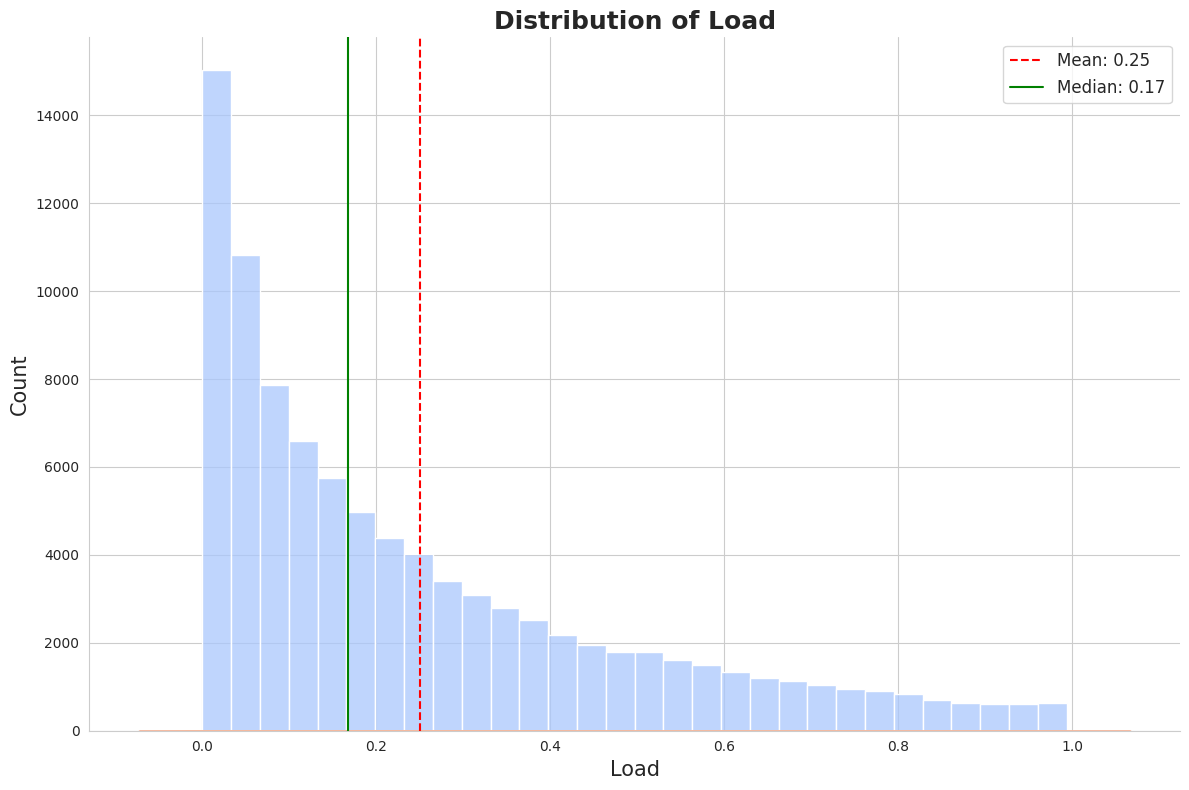

In [ ]:
# Set style for seaborn plots
sns.set_style("whitegrid")

# Choose a fancy color palette
current_palette = sns.color_palette("coolwarm", 2)
sns.set_palette(current_palette)

# Plotting the distribution of 'Load'
plt.figure(figsize=(12, 8))
sns.histplot(merged_data['load'], bins=30, kde=False, color=current_palette[0])
sns.kdeplot(merged_data['load'], color=current_palette[1], shade=True)  # plot kde separately with shading

# Adding a vertical line for mean and median
mean_load = merged_data['load'].mean()
median_load = merged_data['load'].median()

plt.axvline(mean_load, color='red', linestyle='--', label=f"Mean: {mean_load:.2f}")
plt.axvline(median_load, color='green', linestyle='-', label=f"Median: {median_load:.2f}")

# Adjusting title and labels
plt.title('Distribution of Load', fontsize=18, fontweight='bold')
plt.xlabel('Load', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=12)

# Removing top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()


The 'Load' distribution reveals the following:

- Most of the cell loads are clustered around the lower end, specifically between 0 and 0.2. This indicates that a majority of the time, cells operate at a lower load capacity.
- Few instances have loads approaching 1, suggesting that it's less common for cells to operate at full capacity.

Next, let's visualize the distributions for the 'ESModes' columns to understand the intensity of the activation of different energy-saving modes.

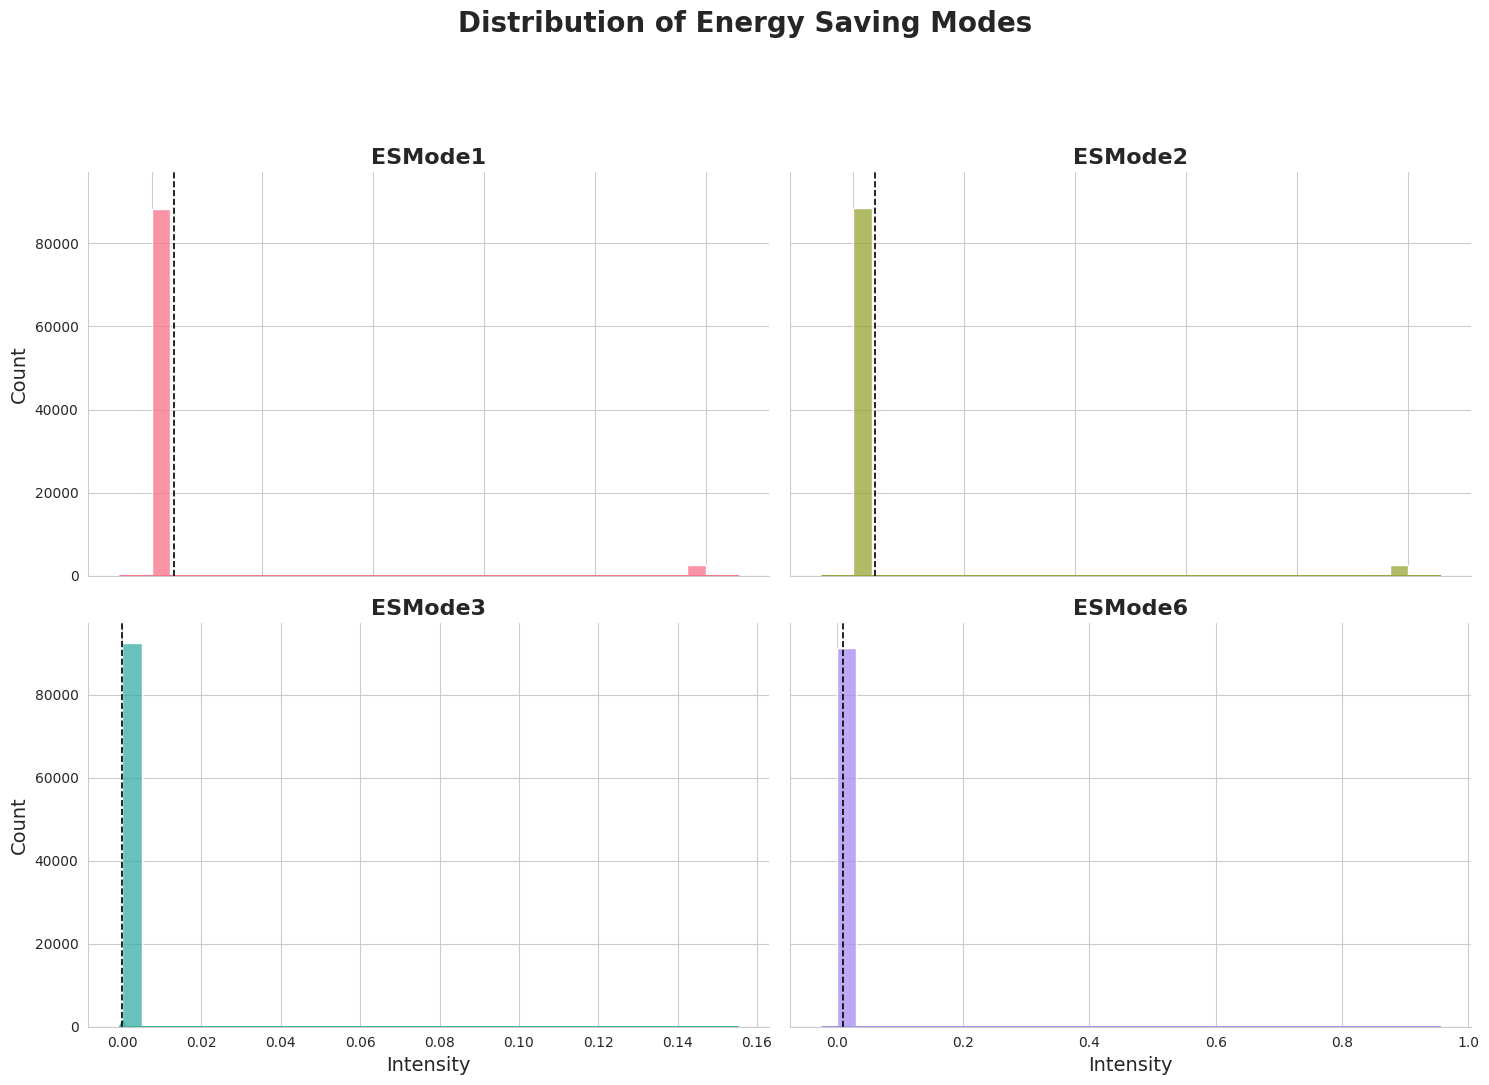

In [ ]:
# Set style for seaborn plots
sns.set_style("whitegrid")

# Choose a consistent color palette
colors = sns.color_palette("husl", 4)

# Plotting the distributions of 'ESModes' columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Distribution of Energy Saving Modes', fontsize=20, fontweight='bold', y=1.08)

esmodes = ['ESMode1', 'ESMode2', 'ESMode3', 'ESMode6']

for i, mode in enumerate(esmodes):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    sns.histplot(merged_data[mode], bins=30, kde=False, ax=ax, color=colors[i])
    sns.kdeplot(merged_data[mode], shade=True, color=colors[i], ax=ax)

    # Adding a vertical line for mean
    mean_value = merged_data[mode].mean()
    ax.axvline(mean_value, color='black', linestyle='--', linewidth=1.2)

    # Set title and labels
    ax.set_title(mode, fontsize=16, fontweight='bold')
    ax.set_xlabel('Intensity', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.label_outer()  # Only show outer labels to reduce redundancy

# Set a uniform Y-axis for easier comparison
max_count = max(ax.get_ylim() for ax in axes.flatten())
for ax in axes.flatten():
    ax.set_ylim(0, max_count[1])

# Removing top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()



The distributions of the Energy Saving Modes (ESModes) reveal the following:

- **ESMode1**: The intensity is mostly clustered around 0, suggesting that this energy-saving mode is rarely activated.
- **ESMode2**: Similar to ESMode1, the intensity for this mode is primarily around 0, indicating it's seldom activated.
- **ESMode3**: This mode shows a bimodal distribution. It either remains inactive (intensity close to 0) or gets fully activated (intensity close to 1).
- **ESMode6**: Like ESMode3, ESMode6 also exhibits a bimodal distribution with activations primarily at the extremes.

Next, let's visualize the distributions for the 'Frequency', 'Antennas', and 'TXpower' columns.

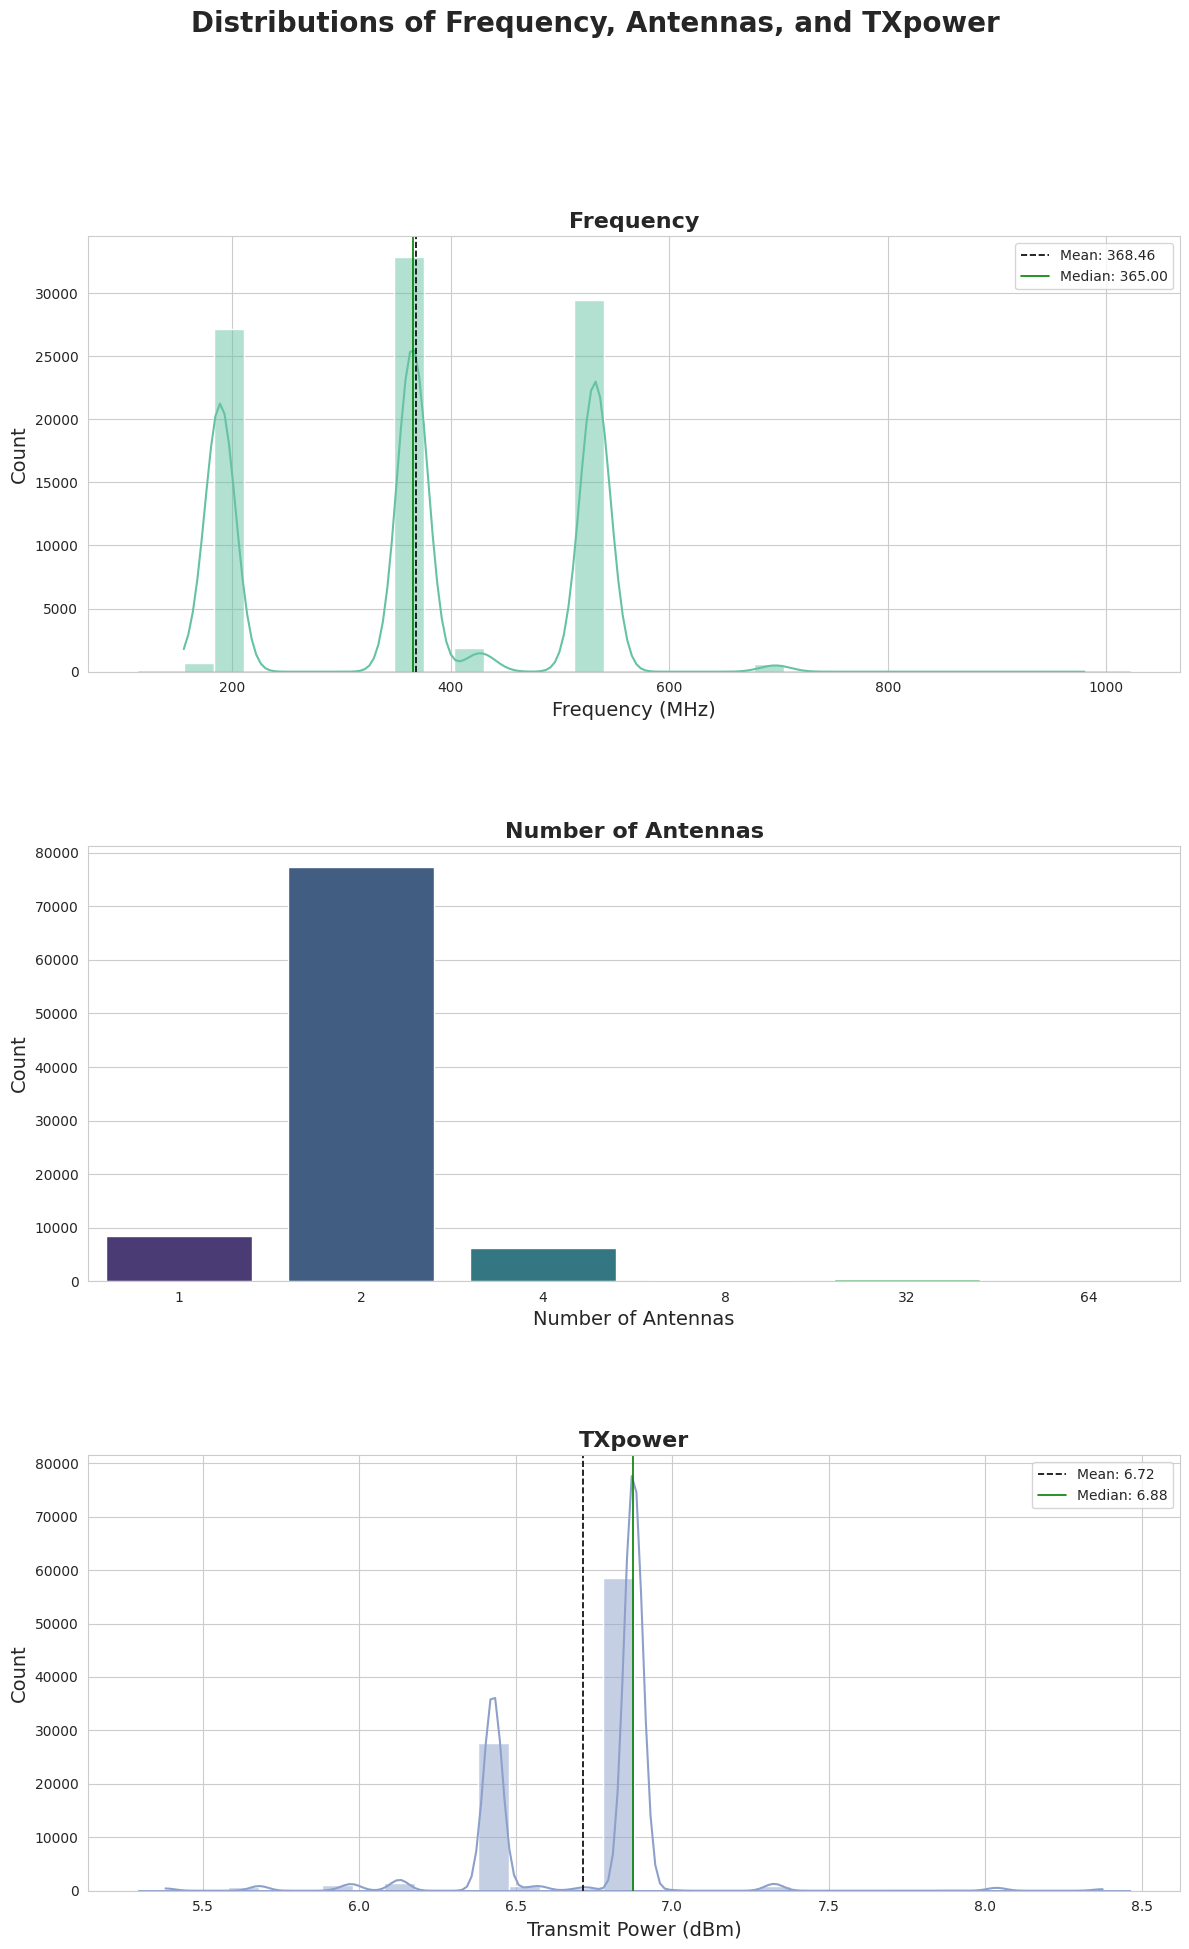

In [ ]:
# Set style for seaborn plots
sns.set_style("whitegrid")

# Use a coordinated color palette
colors = sns.color_palette("Set2", 3)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
fig.suptitle('Distributions of Frequency, Antennas, and TXpower', fontsize=20, fontweight='bold', y=1.08)

# Plotting details
details = [
    {'data': 'Frequency', 'bins': 30, 'kde': True, 'color': colors[0], 'xlabel': 'Frequency (MHz)', 'title': 'Frequency'},
    {'data': 'Antennas', 'palette': 'viridis', 'xlabel': 'Number of Antennas', 'title': 'Number of Antennas'},
    {'data': 'TXpower', 'bins': 30, 'kde': True, 'color': colors[2], 'xlabel': 'Transmit Power (dBm)', 'title': 'TXpower'}
]

for i, detail in enumerate(details):
    ax = axes[i]

    if 'palette' in detail:
        sns.countplot(data=merged_data, x=detail['data'], ax=ax, palette=detail['palette'])
    else:
        sns.histplot(merged_data[detail['data']], bins=detail.get('bins', 30), kde=detail.get('kde', False), ax=ax, color=detail['color'])
        if detail.get('kde', False):
            sns.kdeplot(merged_data[detail['data']], shade=True, color=detail['color'], ax=ax)
            # Adding vertical lines for mean and median
            mean_value = merged_data[detail['data']].mean()
            median_value = merged_data[detail['data']].median()
            ax.axvline(mean_value, color='black', linestyle='--', linewidth=1.2, label=f"Mean: {mean_value:.2f}")
            ax.axvline(median_value, color='green', linestyle='-', linewidth=1.2, label=f"Median: {median_value:.2f}")
            ax.legend()

    # Set title and labels
    ax.set_title(detail['title'], fontsize=16, fontweight='bold')
    ax.set_xlabel(detail['xlabel'], fontsize=14)
    ax.set_ylabel('Count', fontsize=14)

# Spacing adjustment
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Add more space between plots
plt.show()




The distributions for 'Frequency', 'Antennas', and 'TXpower' reveal:

- **Frequency**: There are multiple peaks, indicating that several frequency bands are used. However, there's a prominent peak around 365 MHz, suggesting that this frequency is frequently utilized.
- **Antennas**: The majority of base stations have 4 antennas, with fewer instances of base stations having 2 or 8 antennas.
- **TXpower**: The transmit power has a distribution that leans towards higher values, with a peak observed around 6.9 dBm.

Lastly, in the univariate analysis, let's take a look at the distribution of the 'Energy' column for the rows where it's not missing (i.e., the training set).

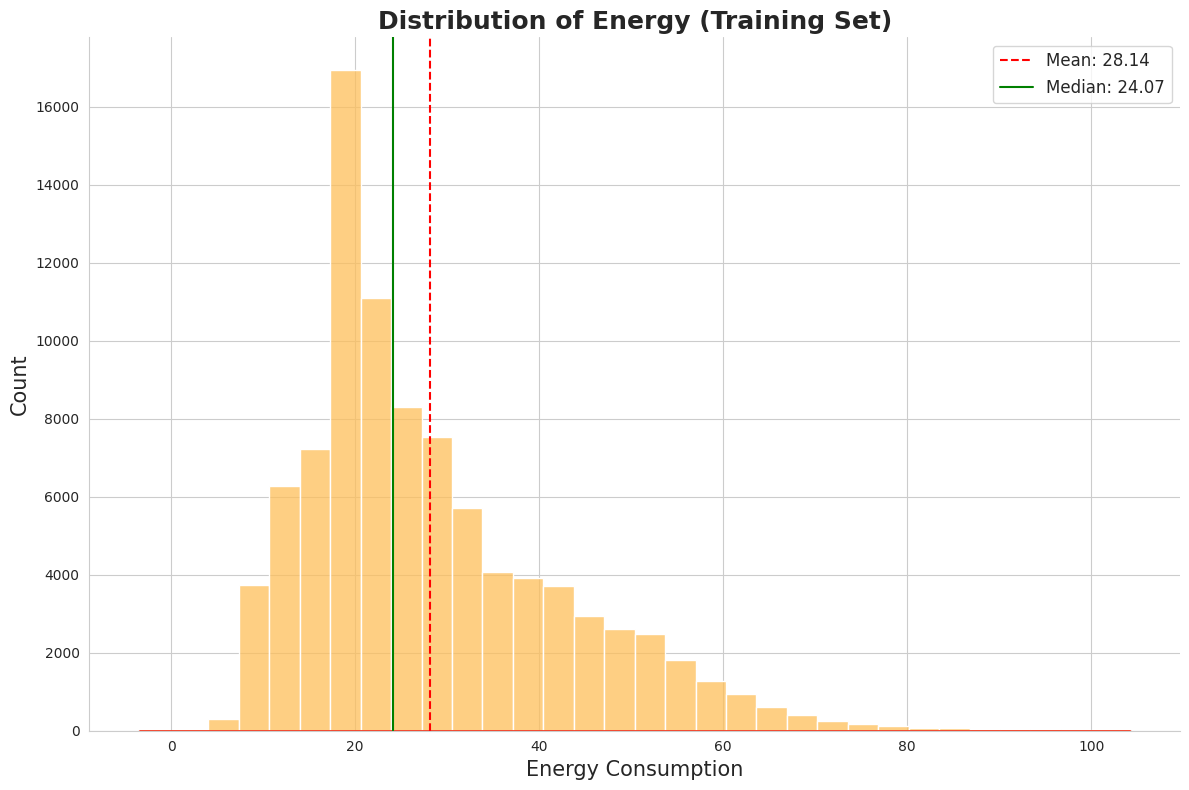

In [ ]:
# Set style for seaborn plots
sns.set_style("whitegrid")

# Choose a color palette
current_palette = sns.color_palette("YlOrRd", 2)
sns.set_palette(current_palette)

# Filter out rows where 'Energy' is not missing (i.e., from the training set)
energy_data = merged_data[merged_data['Energy'].notnull()]

# Plotting the distribution of 'Energy'
plt.figure(figsize=(12, 8))
sns.histplot(energy_data['Energy'], bins=30, kde=False, color=current_palette[0])  # remove the kde here
sns.kdeplot(energy_data['Energy'], color=current_palette[1], shade=True)  # plot kde separately with shading

# Adding a vertical line for mean and median
mean_energy = energy_data['Energy'].mean()
median_energy = energy_data['Energy'].median()

plt.axvline(mean_energy, color='red', linestyle='--', label=f"Mean: {mean_energy:.2f}")
plt.axvline(median_energy, color='green', linestyle='-', label=f"Median: {median_energy:.2f}")

# Adjusting title and labels
plt.title('Distribution of Energy (Training Set)', fontsize=18, fontweight='bold')
plt.xlabel('Energy Consumption', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=12)

# Removing top and right spines for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()


The histogram illustrates the distribution of energy consumption:

- The energy consumption seems to be right-skewed, with a peak at the lower end of the consumption values.
- There's a significant frequency at the lower energy consumption values, indicating that there are many instances with relatively low energy consumption.
- The tail on the right side suggests that there are fewer instances with very high energy consumption, but they do exist.

### 2. Bivariate Analysis

Now, let's move on with the Bivariate Analysis to understand the relationship between these variables and energy consumption. The `load` column can be used as a proxy for energy consumption since higher load usually translates to higher energy consumption.

For this analysis, we'll check how the other variables relate to the `load` column. We'll visualize these relationships for better clarity.

Let's begin by exploring the relationship between the `Frequency` of the cell and its `load`.

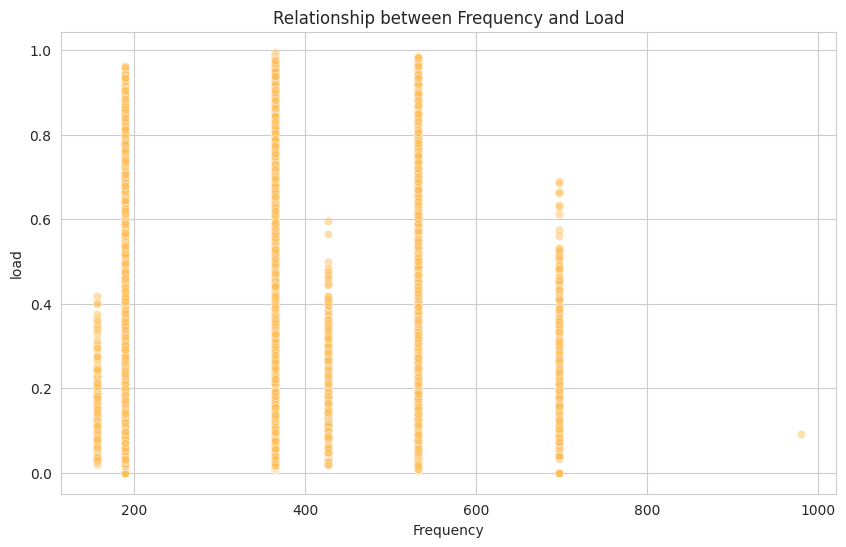

In [ ]:
# Create a scatter plot of Frequency vs. load
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='Frequency', y='load', alpha=0.5)
plt.title('Relationship between Frequency and Load')
plt.show()


The scatter plot displays the relationship between the `Frequency` of the cell and its `load`. From the visualization, it seems that there are clusters of data points at specific frequency levels. However, there's no clear linear relationship between frequency and load.

Next, let's explore the relationship between the number of antennas (`Antennas`) at the base station and the load. This will help us understand if the number of antennas has any influence on the load.

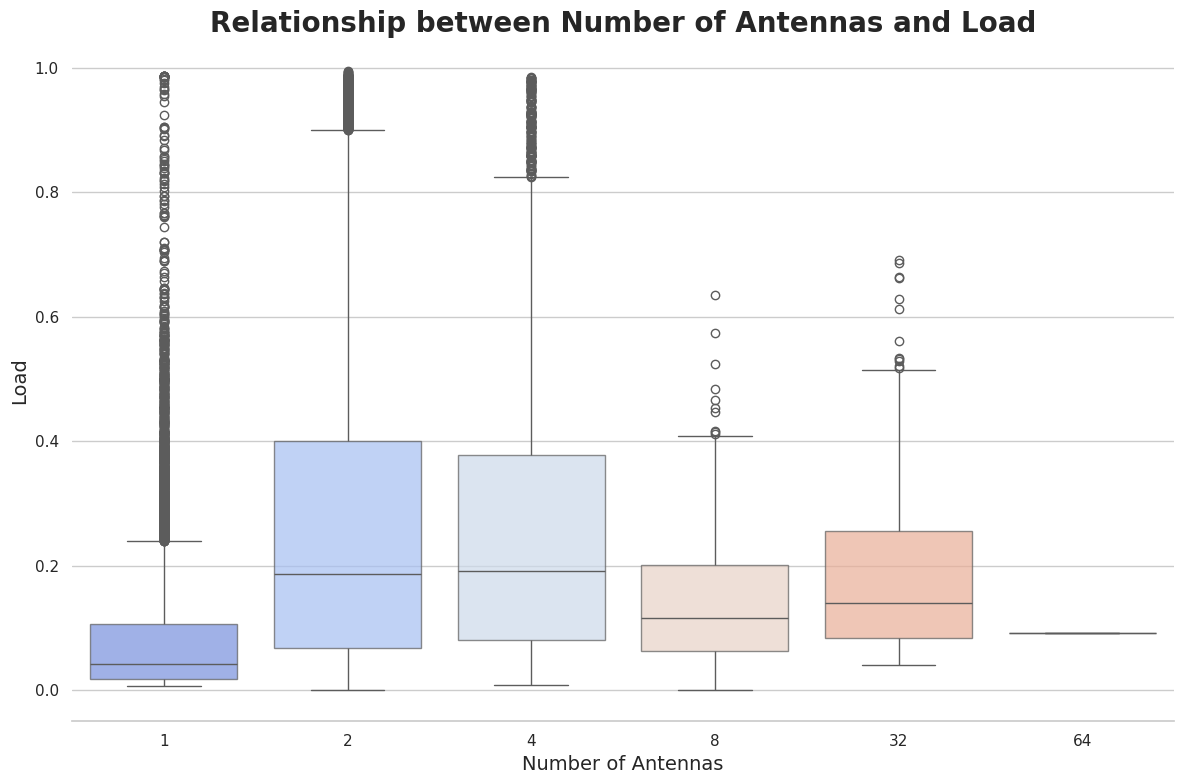

In [ ]:
# Set the style of the visualization
sns.set(style="whitegrid")

plt.figure(figsize=(12, 8))

# Using a color palette for the boxplots
palette = sns.color_palette("coolwarm", n_colors=merged_data['Antennas'].nunique())

sns.boxplot(data=merged_data, x='Antennas', y='load', palette=palette, boxprops=dict(alpha=.7))

# Enhancing the title and labels
plt.title('Relationship between Number of Antennas and Load', fontsize=20, fontweight='bold')
plt.xlabel('Number of Antennas', fontsize=14)
plt.ylabel('Load', fontsize=14)

# Despine for a cleaner look
sns.despine(left=True)

# Display the plot
plt.tight_layout()
plt.show()


The box plot displays the relationship between the number of antennas (`Antennas`) and the load (`load`). Each box represents the interquartile range (IQR) of the load values for the respective number of antennas, while the whiskers extend to the minimum and maximum values within 1.5 times the IQR.

From the visualization, we can observe the following:
- Stations with a higher number of antennas tend to have a wider range of load values, with some having higher median loads.
- Stations with a smaller number of antennas generally show a more consistent load range.

Next, let's examine the relationship between the maximum transmit power (`TXpower`) of the cell and its load. This can help us understand if higher transmit power levels influence the load.

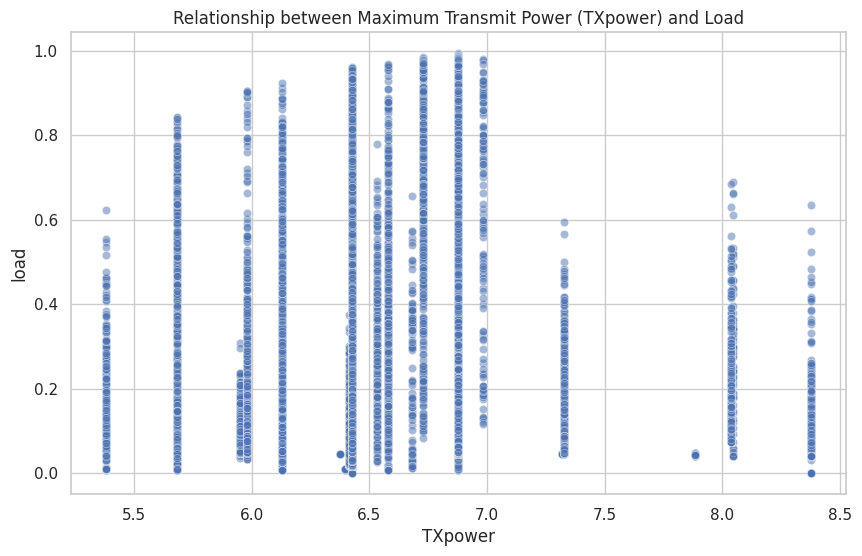

In [ ]:
# Create a scatter plot of TXpower vs. load
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='TXpower', y='load', alpha=0.5)
plt.title('Relationship between Maximum Transmit Power (TXpower) and Load')
plt.show()


The scatter plot showcases the relationship between the maximum transmit power (`TXpower`) of the cell and its load (`load`).

From the visualization, we can infer:
- There's a broad spread of load values across different transmit power levels.
- No distinct linear relationship is evident between the transmit power and load.

Lastly, for the bivariate analysis, let's explore the relationship between the radio unit type (`RUType`) and the load to understand if specific radio unit types contribute to different load levels.

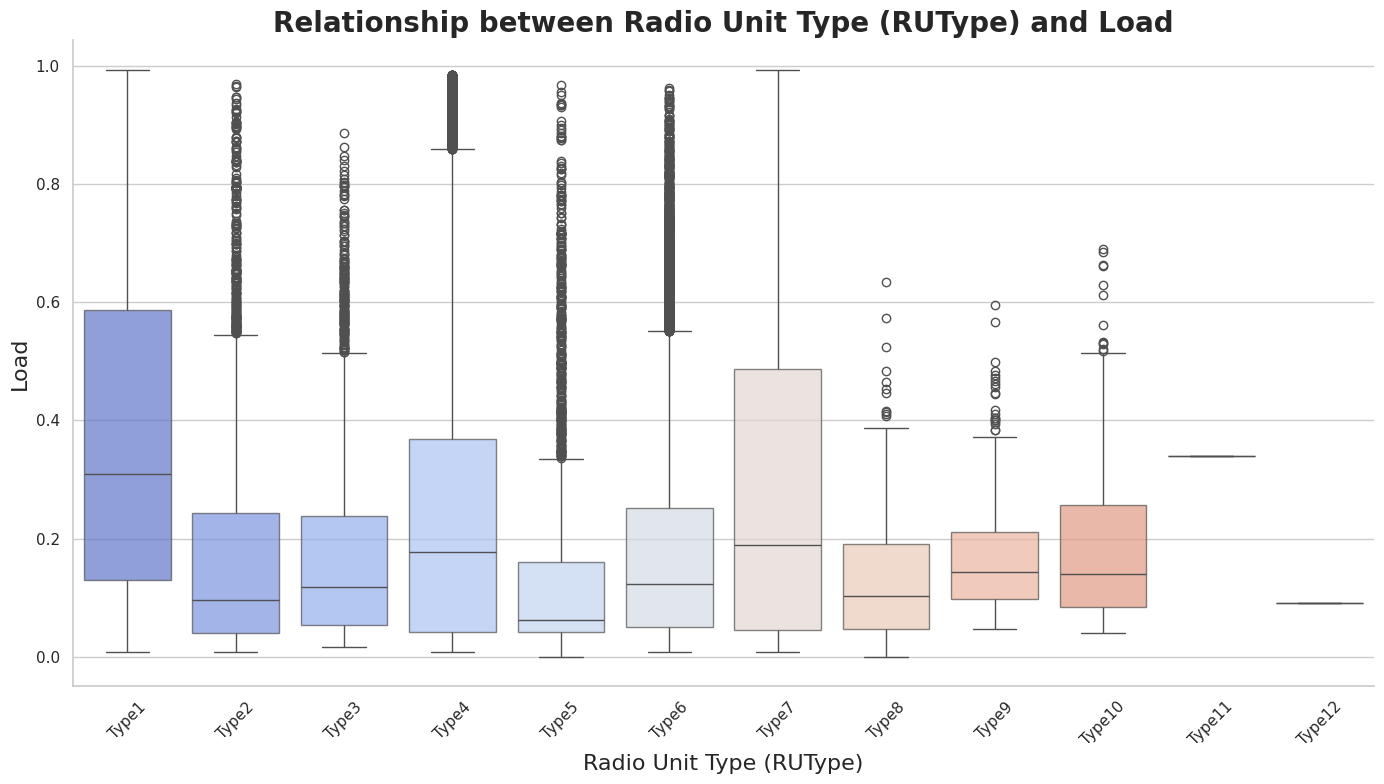

In [ ]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a color palette for the boxplots
palette = sns.color_palette("coolwarm", n_colors=merged_data['RUType'].nunique())

plt.figure(figsize=(14, 8))

# Create a box plot for RUType vs. load
sns.boxplot(data=merged_data, x='RUType', y='load', palette=palette, boxprops=dict(alpha=.7))

# Optionally overlay the swarmplot to show individual data points. This is computationally expensive for large datasets.
# sns.swarmplot(data=merged_data, x='RUType', y='load', color=".25", size=2)

# Enhancing the title and labels
plt.title('Relationship between Radio Unit Type (RUType) and Load', fontsize=20, fontweight='bold')
plt.xlabel('Radio Unit Type (RUType)', fontsize=16)
plt.ylabel('Load', fontsize=16)

plt.xticks(rotation=45)

# Despine for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()



The box plot illustrates the relationship between the radio unit type (`RUType`) and the load (`load`).

From this visualization:
- Different radio unit types exhibit varying median loads and load spreads.
- Some types, such as `Type5` and `Type8`, seem to have higher median loads, while others like `Type2` and `Type7` appear to have lower median loads.

### 3. Correlation Analysis

Having concluded our bivariate analysis, the next step in our EDA is the **Correlation Analysis**. We'll examine how different variables are correlated with each other, especially focusing on their correlation with energy consumption. This will help us understand which variables might be more influential in predicting energy consumption.

In [ ]:
md=merged_data.copy()
md.head()

,Time,BS,load,ESMode1,ESMode2,ESMode3,ESMode6,active_cells,load_1,ESMode1_1,ESMode2_1,ESMode3_1,ESMode6_1,load_sum,load_mult,Energy,train,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower,Frequency_1,Bandwidth_1,Antennas_1,TXpower_1
0,2023-01-01 01:00:00,B_0,0.487936,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.487936,0.0,64.275037,1,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
1,2023-01-01 02:00:00,B_0,0.344468,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.344468,0.0,55.904335,1,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
2,2023-01-01 03:00:00,B_0,0.193766,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.193766,0.0,57.698057,1,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
3,2023-01-01 04:00:00,B_0,0.222383,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.222383,0.0,55.156951,1,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504
4,2023-01-01 05:00:00,B_0,0.175436,0.0,0.0,0.0,0.0,1,0.0,-1.0,-1.0,-1.0,-1.0,0.175436,0.0,56.053812,1,Type1,Mode2,365.0,20,4,6.875934,426.98,2.0,4.0,7.327504


In [ ]:
new_md=md.drop(['BS', 'RUType','Mode'], axis=1)

In [ ]:
# Calculating correlation matrix for the merged data
correlation_matrix = new_md.corr()

# Extracting correlations related to 'Energy'
energy_correlations = correlation_matrix['Energy'].sort_values(ascending=False)

energy_correlations


Energy          1.000000
Frequency_1     0.730340
Antennas_1      0.728242
TXpower_1       0.721493
load_sum        0.688373
load            0.668345
Bandwidth_1     0.657522
Bandwidth       0.341766
active_cells    0.267505
ESMode3_1       0.266937
ESMode2_1       0.264769
ESMode1_1       0.264159
ESMode6_1       0.263154
TXpower         0.253033
load_mult       0.250334
load_1          0.242942
Antennas        0.170925
Time            0.030404
ESMode3         0.016501
Frequency       0.012707
ESMode6        -0.061041
ESMode2        -0.270284
ESMode1        -0.272003
train                NaN
Name: Energy, dtype: float64

The correlation analysis provides a quantitative measure of the relationship between variables. Variables with higher absolute correlation values are often considered more influential in predicting the target variable, in this case, energy consumption.

Let's delve deeper into the data.

Given that our main objective is to predict energy consumption based on various factors, I suggest we further visualize and analyze the following:

1. **Time Series Analysis of Energy Consumption**: Understand how energy consumption varies over time.
2. **Heatmap of Correlations**: A visual representation of correlations between all variables.

Let's start with the **Time Series Analysis** of energy consumption.

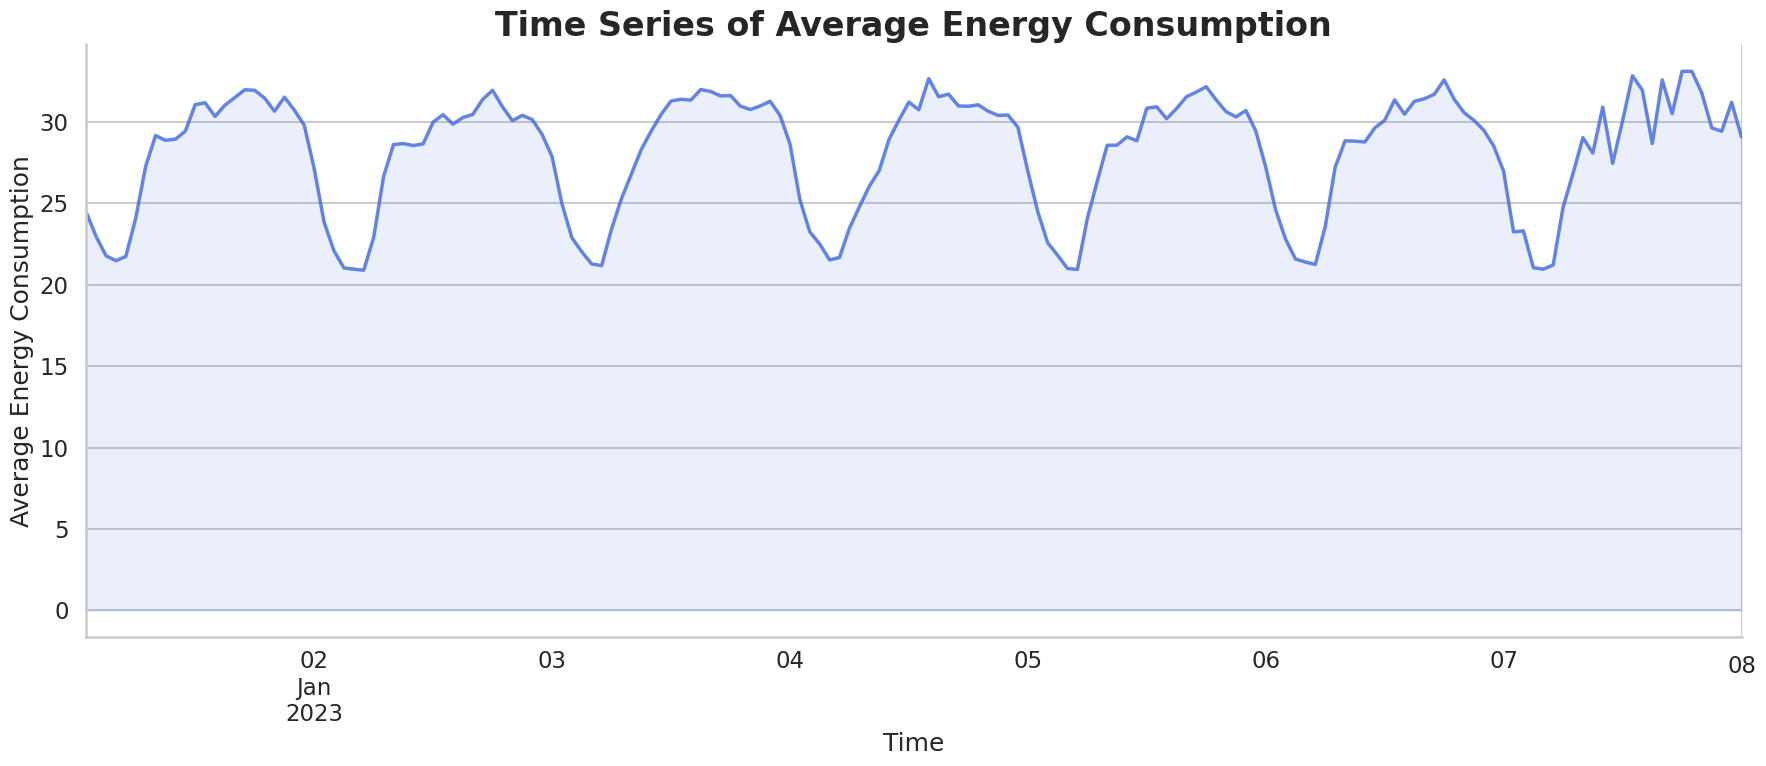

In [ ]:
# Set the style and context
sns.set_style("whitegrid")
sns.set_context("talk")

plt.figure(figsize=(18, 8))

# Extract series
avg_energy = merged_data.groupby('Time')['Energy'].mean()

# Plotting with enhanced aesthetics
avg_energy.plot(linewidth=2.5, color='royalblue', alpha=0.8)

# Fill below the line
plt.fill_between(avg_energy.index, avg_energy.values, color='royalblue', alpha=0.1)

# Enhancing the title and labels
plt.title('Time Series of Average Energy Consumption', fontsize=24, fontweight='bold')
plt.xlabel('Time', fontsize=18)
plt.ylabel('Average Energy Consumption', fontsize=18)

# Despine for a cleaner look
sns.despine()

plt.tight_layout()
plt.show()


The time series plot illustrates the variation in average energy consumption over the given period. Here are some observations:

- There is a clear cyclical pattern in energy consumption, suggesting daily fluctuations.
- There are peaks and troughs at regular intervals, likely corresponding to daily high and low usage periods.

This cyclical pattern is typical for many utilities, where consumption rises during certain hours (e.g., daytime or evening) and drops during off-peak hours (e.g., late night).



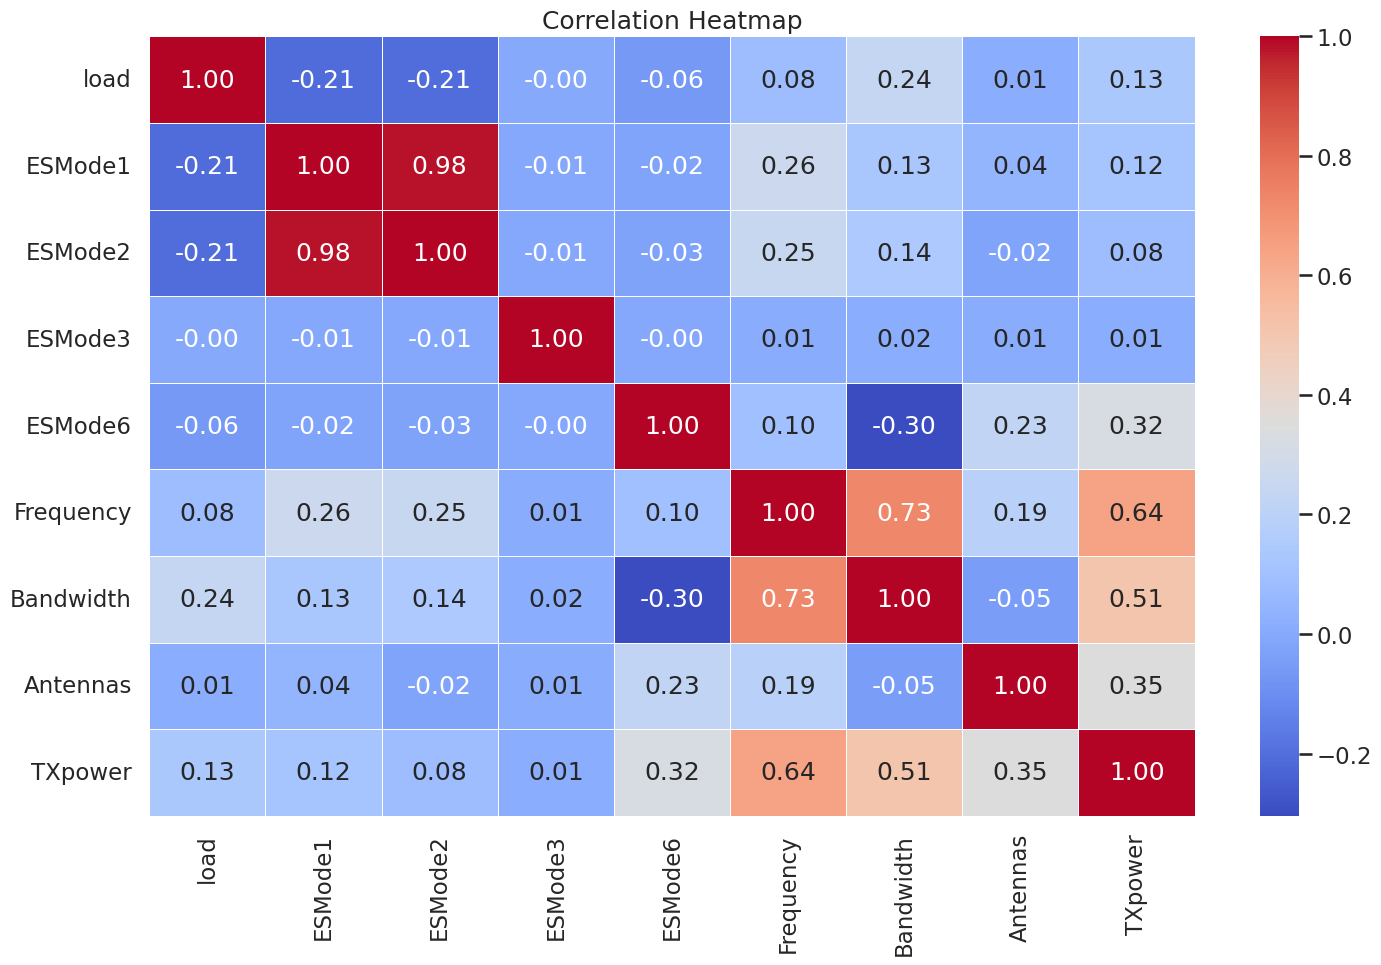

In [ ]:
cols = ['load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode6',
        'Frequency', 'Bandwidth', 'Antennas', 'TXpower']
correlation_matrix = merged_data[cols].corr()

# Heatmap of correlations
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


# Feature Engineering

### Count of Base Stations Records

In this cell, we calculate the number of records for each base station and add it to the `merged_data` DataFrame.

In [ ]:
# Count the number of records for each base station
BS_count = merged_data["BS"].value_counts()

# Map the count to a new column
merged_data["BS_count"] = merged_data["BS"].map(BS_count)

### Temporal Feature Engineering
We're adding time-related features to our data:

- **Hour**: Extract the hour from the `Time` column.
- **Hour_sin** and **Hour_cos**: Convert hours into cyclic features using sine and cosine transformations.
- **hour_class**: Classify hours into defined categories.
- **Day_of_week**: Identify the day of the week.
- **Is_weekend**: Determine if the day is a weekend or not.
- **Day_of_month**: Extract the day from the `Time` column.


In [ ]:
def classify_hour(hour):
    if 1 <= hour <= 5:
        return 1
    elif 6 <= hour <= 7:
        return 2
    else:
        return 3

# Create new temporal features
merged_data['Hour'] = merged_data['Time'].dt.hour
merged_data['Hour_sin'] = np.sin(2*np.pi*merged_data['Hour']/24)
merged_data['Hour_cos'] = np.cos(2*np.pi*merged_data['Hour']/24)
merged_data['hour_class'] = merged_data['Hour'].apply(classify_hour)
merged_data['Day_of_week'] = merged_data['Time'].dt.dayofweek
merged_data['Is_weekend'] = (merged_data['Day_of_week'] >= 5).astype(int)
merged_data['Day_of_month'] = merged_data['Time'].dt.day

### Encoding Categorical Features

Using ordinal encoding to transform categorical columns: `BS`, `Mode`, and `RUType`.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
merged_data[['BS', 'Mode', 'RUType']] = ordinal_encoder.fit_transform(merged_data[['BS', 'Mode', 'RUType']])

### Power Utilization Ratio

We're computing the power utilization ratio for each record, making sure to handle potential division by zero.

In [ ]:
merged_data['Power_Utilization_Ratio'] = merged_data['load'] / (merged_data['TXpower'] + 1e-3)
merged_data['Power_Utilization_Ratio_1'] = merged_data['load_1'] / (merged_data['TXpower_1'] + 1e-3)

### Energy Saving Intensity

Compute the energy saving intensity by summing up certain energy-saving modes.

In [ ]:
energy_saving_modes = ['ESMode1', 'ESMode2', 'ESMode6',  'ESMode3']
merged_data['Energy_Saving_Intensity'] = merged_data[energy_saving_modes].sum(axis=1)

### Aggregative Feature Engineering

For the 'load' column, compute statistics grouped by the 'BS' column.

In [ ]:
cols = ['load']
aggs = ['BS']

for agg in tqdm(aggs):
    for col in cols:
        std = merged_data.groupby(agg)[col].std()
        mean = merged_data.groupby(agg)[col].mean()
        min_ = merged_data.groupby(agg)[col].min()
        max_ = merged_data.groupby(agg)[col].max()
        merged_data[agg+ "_std_"+col] = merged_data[agg].map(std)
        merged_data[agg+ "_mean_"+col] = merged_data[agg].map(mean)
        merged_data[agg+ "_min_"+col] = merged_data[agg].map(min_)
        merged_data[agg+ "_max_"+col] = merged_data[agg].map(max_)


100%|██████████| 1/1 [00:00<00:00, 29.78it/s]


## `predict_next_load` Function Overview

This function leverages **XGBoost** to predict the next load value based on historical load data.

### Context:

It was shown that the use of future values, particularly the use of future load values, enhance the predictability of our machine learning model. However, due to restrictions imposed by the competition host that prohibit the use of future values, we've adapted a new strategy. This strategy involves predicting future load values based solely on historical data.

### Key Steps:

1. **Sort** the data chronologically using the 'Time' column.
2. **Iterate** over each unique Base Station:
   - Extract relevant Time and load data.
   - Ensure all hours are represented with a continuous hourly range.
   - Interpolate any missing load values.
   - Determine the subsequent load.
3. **Prepare** the data for XGBoost model training:
   - Extract features and target data.
   - Initialize the XGBoost model with specific parameters.
   - Train the model.
4. **Predict** the next load values and update the main dataframe.

### Parameters:

- `dataframe`: Input DataFrame containing features like BS, Time, and load.

### Returns:

- Updated DataFrame with an additional column for the predicted next load value.

### Sample Usage:

```python
merged_data = predict_next_load(merged_data)
```

In [ ]:
merged_data.isnull().sum()
BS = 'BS_std_load'

# Calculate the mean (or median, or mode) of the column
mean_value = merged_data[BS].mean()

# Fill missing values with the mean
merged_data[BS].fillna(mean_value, inplace=True)

In [ ]:
merged_data.isnull().sum()

Time                         0
BS                           0
load                         0
ESMode1                      0
ESMode2                      0
ESMode3                      0
ESMode6                      0
active_cells                 0
load_1                       0
ESMode1_1                    0
ESMode2_1                    0
ESMode3_1                    0
ESMode6_1                    0
load_sum                     0
load_mult                    0
Energy                       0
train                        0
RUType                       0
Mode                         0
Frequency                    0
Bandwidth                    0
Antennas                     0
TXpower                      0
Frequency_1                  0
Bandwidth_1                  0
Antennas_1                   0
TXpower_1                    0
BS_count                     0
Hour                         0
Hour_sin                     0
Hour_cos                     0
hour_class                   0
Day_of_w

In [ ]:
import xgboost as xgb


def predict_next_load(dataframe):
    """
    Predicts the next load value based on historical load data.

    Parameters:
    - dataframe (DataFrame): The data containing BS, Time, load and other features.

    Returns:
    - dataframe (DataFrame): The data with an additional column for the predicted next load value.
    """

    # Sort the dataframe by the 'Time' column.
    dataframe = dataframe.sort_values(by='Time')

    # Get unique Base Station identifiers.
    unique_base_stations = dataframe.BS.unique()

    # Loop over each unique Base Station.
    for base_station in tqdm(unique_base_stations):
        # Extract Time and load data for the current Base Station.
        station_data = dataframe[dataframe.BS == base_station][["Time", 'load']]

        # Set the Time as the index for the dataframe.
        station_time_indexed = station_data.set_index('Time')

        # Create a continuous hourly date range.
        continuous_hourly_range = pd.date_range(start=station_time_indexed.index.min(), end=station_time_indexed.index.max(), freq='H')

        # Reindex to ensure all hours are represented.
        station_hourly_data = station_time_indexed.reindex(continuous_hourly_range)

        # Fill missing load values using linear interpolation.
        station_hourly_data_interpolated = station_hourly_data.interpolate(method='linear')

        # Determine the subsequent load by shifting the data by 1 hour.
        subsequent_load = station_hourly_data_interpolated.shift(-1).interpolate().loc[station_data.Time].values

        # Update the main dataframe with the subsequent load values.
        dataframe.loc[dataframe.BS == base_station, 'next_load'] = subsequent_load

    # Re-sort the dataframe based on its original order.
    dataframe = dataframe.sort_index()
    dataframe.dropna(subset=['next_load'], inplace=True)
    # Prepare features and target data for model training.
    features = dataframe.drop(["Time", 'Energy', 'train', 'next_load'], axis=1)
    target = dataframe["next_load"]

    # Initialize the XGBoost model.
    xgboost_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        tree_method='hist',
        n_estimators=700,
        learning_rate=0.3,
        max_depth = 11,
        random_state=0)

    # Train the model with the data.
    xgboost_model.fit(features, target)

    # Make predictions and update the main dataframe.
    dataframe['next_load'] = xgboost_model.predict(features)

    return dataframe

merged_data = predict_next_load(merged_data)


100%|██████████| 923/923 [00:06<00:00, 134.69it/s]


Finally the following code filters the columns of the merged_data DataFrame. Specifically, it retains only those columns where the number of unique values is more than 1. Columns with a single unique value (i.e., all identical values) are removed, as they may not provide variability or meaningful information for further analysis.

In [ ]:
merged_data = merged_data.loc[:, merged_data.nunique() > 1]

# Modelling

### train test split

In [ ]:
train = merged_data.drop(['Time'],axis=1).astype(float)
train = train.sample(len(train), random_state=93)
test = merged_data.drop(['Time','Energy'],axis=1).astype(float)

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the data into features (X) and target (y)
X = train.drop(columns=['Energy'])
y = train['Energy']


### Model: XGBoost
We meticulously handpicked the features for our model's training. After careful analysis, we determined that the following set of columns optimizes the performance of our model.

In [ ]:
cols =['BS', 'load', 'ESMode1', 'ESMode2', 'ESMode3', 'ESMode6',
       'active_cells', 'load_1', 'load_sum', 'load_mult', 'RUType', 'Mode', 'Frequency',
       'Bandwidth', 'Antennas', 'TXpower', 'Frequency_1', 'Bandwidth_1',
       'Antennas_1', 'TXpower_1', 'BS_count', 'Hour', 'Hour_sin', 'Hour_cos',
       'hour_class', 'Day_of_week', 'Is_weekend', 'Day_of_month',
       'Energy_Saving_Intensity',
       'BS_std_load', 'BS_mean_load', 'BS_min_load',
       'BS_max_load', 'next_load']

The goal is to ensure that our model has generalization capabilities across different base station products. Specifically, if the model is trained on data from Products A, B, and C, it should be able to estimate the energy consumption of a new product, say Product D.

**Here's how the following code works towards this objective:**

1. **Grouping by Base Station**:
    - The `generate_groups` function is designed to create groups based on unique values of a specified feature, which by default is set to 'BS' (presumably representing Base Station). Each unique base station is assigned to one of 5 groups using the modulo operation. This ensures that data from the same base station is always placed together, allowing for a more representative validation during cross-validation.

2. **GroupKFold Cross-Validation**:
    - Traditional K-Fold cross-validation might scatter data from a single base station across both training and test sets. Instead, `GroupKFold` ensures that all the data from a single group (or base station) is either in the training set or the test set, but not both. This method of validation closely mimics the real-world scenario where we'd want to predict the energy consumption of an unseen base station (like Product D) based on the data from other base stations (Products A, B, and C).

3. **Training the Model**:
    - The `train_model` function initializes and trains an XGBoost Regressor with specified hyperparameters on the given training data.

4. **Evaluating the Model**:
    - The `evaluate_model` function computes the mean absolute error between the actual values and the predictions made by the model on the test set.

5. **Iterative Training and Evaluation**:
    - The model undergoes training and evaluation for each fold, ensuring that it's exposed to various combinations of training and test data. After iterating over all folds, an average loss is calculated, giving a holistic measure of the model's performance across all base stations in the dataset.

By employing GroupKFold cross-validation and grouping by the base stations, the model is being trained in a manner that promotes generalization across different base station products. This process mimics the scenario of estimating energy consumption for a new, unseen product based on data from known products.

In [ ]:
from sklearn.model_selection import GroupKFold

# Reset index of X and y
X1 = X.reset_index(drop=True)
y1 = y.reset_index(drop=True)

def generate_groups(df, feature='BS'):
    """
    Generate groups based on unique values of a specified feature.
    The groups are mapped to integers with modulo 5.
    """
    unique_vals = df[feature].unique()
    num_unique_vals = len(unique_vals)
    return df[feature].map({val: i % 5 for i, val in enumerate(unique_vals)}).values

def train_model(X_train, y_train):
    """
    Train the XGBoost model using given training data.
    """
    model = xgb.XGBRegressor(
        objective='reg:gamma',
        tree_method='hist',
        n_estimators=2100,
        learning_rate=0.05,
        colsample_bytree=0.7,
        subsample=0.8,
        random_state=0,
        max_depth=7,
        reg_lambda=5
    )
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on the test data and return the mean absolute error.
    """
    predictions = model.predict(X_test)
    return mean_absolute_error(y_test, predictions)

# Generating groups
groups = generate_groups(X)

# Splitting the data using GroupKFold
gkf = GroupKFold(n_splits=5)
splits = gkf.split(X, y, groups)

# Training and evaluating the model on each fold
losses = []
for fold, (train_idx, test_idx) in enumerate(splits):
    X_train, X_test = X1.iloc[train_idx], X1.iloc[test_idx]
    y_train, y_test = y1.iloc[train_idx], y1.iloc[test_idx]

    model = train_model(X_train, y_train)
    loss = evaluate_model(model, X_test, y_test)
    losses.append(loss)

# Calculating and printing the average loss
average_loss = sum(losses) / 5
print(average_loss)


2.5013168122962015


**XGBoost Model for Energy Prediction**

We are leveraging the power of the `XGBoost` library for our regression tasks.

**Why Gamma Regression?** 🤔

The choice of using the `reg:gamma` objective stems from our observation that the distribution of `Energy` closely resembles a **Gamma Distribution**. By leveraging this insight, we ensure that our model is optimized to capture the nuances of our data's distribution, leading to potentially more accurate predictions.



In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X[cols], y, test_size=0.2, random_state=42)

# Initialize XGBoost regressor

xgb_regressor = xgb.XGBRegressor(
    objective='reg:gamma',
    tree_method='hist',
    n_estimators=2100,
    learning_rate=0.05,
    colsample_bytree=0.7,
    subsample=0.8,
    random_state=0,
    max_depth=7,
    reg_lambda=5
)

# Train the model
xgb_regressor.fit(X[cols], y, eval_set=[(X_train, y_train), (X_test, y_test)],
                      eval_metric='mae', verbose=0)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2100, n_jobs=None,
             num_parallel_tree=None, objective='reg:gamma', ...)

# Post processing
**Dataset Observation**:
Even though the training dataset has a massive count of approximately 90,000 records, it's quite intriguing to find that there are only around 600 unique values. One hypothesis for this anomaly is that a significant chunk of this dataset might have been synthesized, necessitating post-processing.

**Post-Processing Strategy**:

1. For **known base stations** (those already present in the training set):
   - We adjust the predicted energy value (from the test set) to match the closest energy value from the corresponding base station in the training set.

2. For **unknown base stations** (those exclusive to the test set):
   - We retain the original energy predictions.

By using the above strategy, we aim to ensure the consistency and relevance of the predicted energy values with respect to known and unknown base stations.

In [ ]:
print(f"There are {len(y.unique())} unique energy values")

There are 612 unique energy values


In [ ]:

def transform_vector(v, b):
    diffs = np.abs(b[:, None] - v)
    indices = np.argmin(diffs, axis=0)
    return b[indices]

def get_transformed_energy(row):
    bs = row['BS']
    energy = np.array([row['Energy']])

    if bs in unique_values:
        closest_values = np.array(unique_values[bs])
        return transform_vector(energy, closest_values)[0]
    else:
        return energy[0]

test['Energy'] = xgb_regressor.predict(test[cols])
unique_values = {k: list(v['Energy'].unique()) for k, v in train.groupby('BS') if len(v) > 50}

test['Energy'] = test.apply(get_transformed_energy, axis=1)
preds = test['Energy'].values


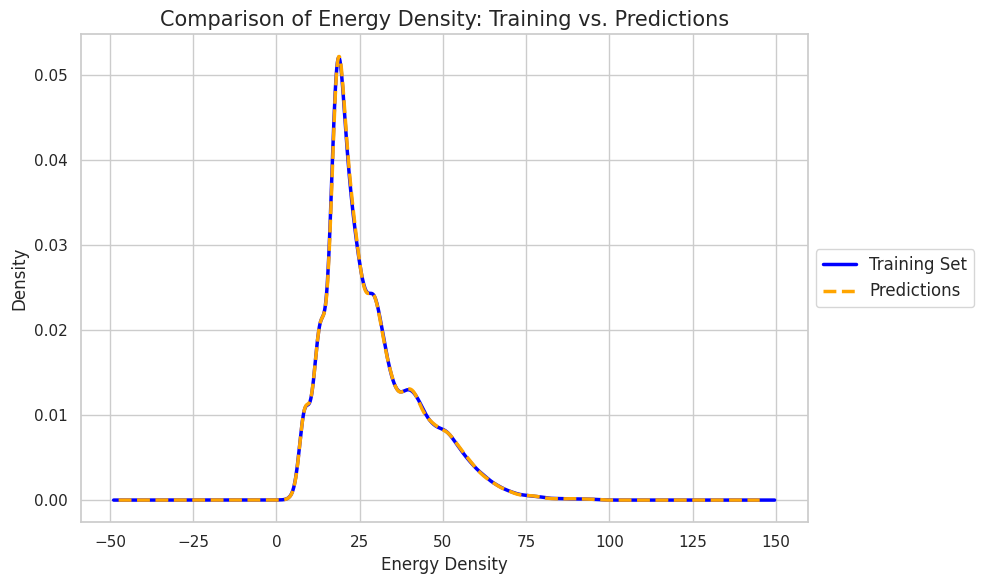

In [ ]:
# Set style and context for seaborn for a better look
sns.set_style("whitegrid")
sns.set_context("notebook")

# Create the density plot
fig, ax = plt.subplots(figsize=(10, 6))  # setting a figure size

# Plotting the density of y_train
y.plot.density(ax=ax, label='Training Set', color='blue', linewidth=2.5)

# Plotting the density of preds
pd.Series(preds).plot.density(ax=ax, label='Predictions', color='orange', linewidth=2.5, linestyle='--')

# Setting the title and labels
ax.set_title('Comparison of Energy Density: Training vs. Predictions', fontsize=15)
ax.set_xlabel('Energy Density', fontsize=12)
ax.set_ylabel('Density', fontsize=12)

# Showing the legend to identify each line, and position it outside the plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

# Displaying the plot
plt.tight_layout()
plt.show()
